**PROJET ANALYSE DE DONNEES**
**Exploiter les spectres galactiques extraits du SDSS pour prédire certaines quantités physiques**

### Accéder aux données

Après s'être rendu sur  le site [SSDS Query / Casjobs](https://skyserver.sdss.org/CasJobs), on a tapé la requête SQL suivante :
```bash
SELECT TOP 100000
    p.objID, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z,
    p.run, p.rerun, p.camcol, p.field,
    s.specObjID, s.plate, s.mjd, s.fiberID,
    p.petroRad_u, p.petroRad_g, p.petroRad_r, p.petroRad_i, p.petroRad_z,
    p.petroFlux_u, p.petroFlux_g, p.petroFlux_r, p.petroFlux_i, p.petroFlux_z,
    p.petroR50_u, p.petroR50_g, p.petroR50_r, p.petroR50_i, p.petroR50_z,
    p.psfMag_u, p.psfMag_g, p.psfMag_r, p.psfMag_i, p.psfMag_z,
    p.expAB_u, p.expAB_g, p.expAB_r, p.expAB_i, p.expAB_z,
    s.z AS redshift, s.class
FROM PhotoObjAll AS p
JOIN SpecObjAll AS s ON p.specObjID = s.specObjID
```

On a choisi de prendre la table ```DR18``` comme contexte puis exécutons la requête. Une fois la commande prête, une page s'affiche avec la requête SQL suivante :
```bash
SELECT *
FROM  Mytable_0
```
```Mytable_0``` est le nom qu'on avons choisi de donner à notre table ici. Après exécution de cette requette, le téléchargement debutera et on peut à présent utiliser notre data !

**Importer les bibliothèques et charger le dataset.**

Nous utilisons les datasets ```photometric``` et ```spectroscopic``` du SDSS.
L’objectif est d’explorer les données, de comprendre leur structure, et par la suite de construire un modèle pour prédire le redshift des galaxies et des quasars.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Load the SDSS dataset
df = pd.read_csv("data/dataset.csv")

**Vérification des valeurs manquantes.**

Nous vérifions si des valeurs manquantes sont présentes dans le jeu de données.
Les données manquantes doivent être traitées avant toute modélisation statistique ou phase d'entraînement.

In [2]:
df.isnull().sum().sum()

np.int64(0)

**Afficher toutes les colonnes pour l’exploration.**

Afin de comprendre la structure du jeu de données et d’inspecter les variables, nous nous assurons que toutes les colonnes sont visibles.
Cela permet d’identifier quelles colonnes correspondent à des mesures physiques, des métadonnées ou des étiquettes de classe.

In [3]:
# Désactiver toute limite d'affichage de colonnes
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)  # Largeur illimitée
pd.set_option("display.max_colwidth", None)  # Largeur de chaque cellule

# Afficher les 10 premières lignes avec toutes les colonnes visibles
df.head(20)

,objID,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specObjID,plate,mjd,fiberID,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,1237648704046760145,198.367594,-0.356065,20.73523,18.85085,17.56961,17.08212,16.70905,752,301,3,366,332185036042299392,295,51985,162,4.617126,5.115590,4.721174,4.684702,5.162075,3.511168,25.518180,81.353650,129.18770,190.042100,1.767043,2.110504,2.036932,2.053084,2.261010,22.04871,20.27086,19.04142,18.61768,18.16375,0.849854,0.809568,0.763818,0.783755,0.719075,0.211824,GALAXY
1,1237648704046760198,198.428206,-0.384406,18.44623,17.23412,16.67523,16.29652,16.07245,752,301,3,366,332189708966717440,295,51985,179,5.532878,5.589859,5.600729,5.354244,5.304190,39.659250,125.105900,213.186100,290.01280,336.886800,2.734408,2.734028,2.720730,2.576809,2.524137,20.34698,19.26615,18.67339,18.33171,18.01228,0.529245,0.550424,0.521570,0.512080,0.483037,0.094445,GALAXY
2,1237648704046760550,198.336859,-0.218801,24.57992,22.96763,22.21550,22.45372,22.82691,752,301,3,366,332194107013228544,295,51985,195,43.766610,2.969290,1.533155,2.969510,43.757050,-0.040059,0.630245,1.160457,0.94205,1.493814,-9999.000000,1.056316,0.807809,1.243051,1.968449,24.25974,23.27652,22.62379,22.95598,22.58121,0.050000,0.150042,0.058668,0.050000,0.050000,3.174457,QSO
3,1237648704046825622,198.462136,-0.219281,19.30241,17.78075,16.90307,16.49114,16.18247,752,301,3,367,332188609455089664,295,51985,175,3.748427,5.855546,5.567865,5.369811,5.497572,16.157750,85.047600,182.182200,258.82040,339.042700,1.568756,2.160283,1.937312,1.818147,1.914507,20.18672,18.81749,17.95659,17.52794,17.23053,0.731522,0.780879,0.822669,0.840207,0.817236,0.121077,GALAXY
4,1237648704046825624,198.466124,-0.254391,20.16626,18.28559,17.22367,16.79652,16.40390,752,301,3,367,332186685309741056,295,51985,168,27.912360,4.671544,5.251847,4.817436,5.149425,13.775220,48.896820,132.852300,193.47120,281.822400,4.686791,2.066747,2.102676,2.048219,2.177020,21.22759,19.41046,18.40081,18.00373,17.58257,0.885392,0.743277,0.761695,0.732215,0.685603,0.138055,GALAXY
5,1237648704046825654,198.493224,-0.256808,19.09543,17.31310,16.35899,15.97224,15.63603,752,301,3,367,332188884332996608,295,51985,176,43.755040,2.868777,2.852538,2.827901,2.873691,25.439210,110.268800,266.156300,377.89710,505.926100,1.837784,1.378804,1.331829,1.306797,1.313619,19.92144,18.18361,17.26347,16.89209,16.56325,0.864026,0.721934,0.673505,0.681313,0.728872,0.138718,GALAXY
6,1237648704046825668,198.501137,-0.350658,19.93487,17.91528,16.87629,16.43629,16.04760,752,301,3,367,332188334577182720,295,51985,174,5.004049,5.202849,5.323276,5.051919,4.989447,9.111118,63.099300,167.760400,244.89990,347.871900,1.890661,2.171092,2.200809,2.088027,2.154626,21.20330,19.24600,18.25201,17.83184,17.43041,0.682248,0.835638,0.818189,0.862818,0.833072,0.120911,GALAXY
7,1237648704046825700,198.539702,-0.323055,20.59683,18.82568,17.65636,17.23815,16.86611,752,301,3,367,332185585798113280,295,51985,164,3.369139,3.106019,2.947591,3.086313,4.476436,4.846580,27.627040,81.833170,121.30410,183.102600,1.322552,1.391850,1.354546,1.380181,1.518395,21.31700,19.66862,18.55658,18.15280,17.82260,0.649986,0.780085,0.836987,0.815756,0.773011,0.176991,GALAXY
8,1237648704046891095,198.701398,-0.412739,19.09171,16.93303,16.00233,15.63252,15.43036,752,301,3,368,332182012385323008,295,51985,151,1.978415,1.582088,1.540958,1.525437,1.482557,22.903200,163.617100,391.359400,548.31160,664.196000,0.966614,0.807051,0.799581,0.800798,0.778099,19.26635,17.16443,16.26453,15.89750,15.76437,0.327707,0.071175,0.104135,0.096623,0.191604,-0.000061,STAR
9,1237648704046891118,198.597214,-0.268027,22.05573,19.20698,17.76519,16.86842,16.38345,752,301,3,368,333353816885848064,296,51984,318,1.959352,1.342583,1.255820,1.263818,1.168554,1.590325,19.834540,74.842530,168.

```objID```, ```specObjID```, ```fiberID``` sont des identifiants uniques, sans signification physique. Ils n’apportent aucune information utile pour l’analyse ou la prédiction.

```run```, ```rerun```, ```camcol```, ```field```, ```plate```, ```mjd``` : ces colonnes décrivent des paramètres techniques liés à l’acquisition des données.
Elles sont pertinentes pour le suivi d'observation astronomique, mais n'ont pas de lien direct avec les propriétés physiques à prédire (```redshift```, ```class```).

In [4]:
df = df.drop(columns=[
    "objID", "specObjID", "run", "rerun", "camcol", "field", 
    "plate", "mjd", "fiberID"
])

In [5]:
df.head(15)

,ra,dec,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,198.367594,-0.356065,20.73523,18.85085,17.56961,17.08212,16.70905,4.617126,5.115590,4.721174,4.684702,5.162075,3.511168,25.518180,81.353650,129.18770,190.042100,1.767043,2.110504,2.036932,2.053084,2.261010,22.04871,20.27086,19.04142,18.61768,18.16375,0.849854,0.809568,0.763818,0.783755,0.719075,0.211824,GALAXY
1,198.428206,-0.384406,18.44623,17.23412,16.67523,16.29652,16.07245,5.532878,5.589859,5.600729,5.354244,5.304190,39.659250,125.105900,213.186100,290.01280,336.886800,2.734408,2.734028,2.720730,2.576809,2.524137,20.34698,19.26615,18.67339,18.33171,18.01228,0.529245,0.550424,0.521570,0.512080,0.483037,0.094445,GALAXY
2,198.336859,-0.218801,24.57992,22.96763,22.21550,22.45372,22.82691,43.766610,2.969290,1.533155,2.969510,43.757050,-0.040059,0.630245,1.160457,0.94205,1.493814,-9999.000000,1.056316,0.807809,1.243051,1.968449,24.25974,23.27652,22.62379,22.95598,22.58121,0.050000,0.150042,0.058668,0.050000,0.050000,3.174457,QSO
3,198.462136,-0.219281,19.30241,17.78075,16.90307,16.49114,16.18247,3.748427,5.855546,5.567865,5.369811,5.497572,16.157750,85.047600,182.182200,258.82040,339.042700,1.568756,2.160283,1.937312,1.818147,1.914507,20.18672,18.81749,17.95659,17.52794,17.23053,0.731522,0.780879,0.822669,0.840207,0.817236,0.121077,GALAXY
4,198.466124,-0.254391,20.16626,18.28559,17.22367,16.79652,16.40390,27.912360,4.671544,5.251847,4.817436,5.149425,13.775220,48.896820,132.852300,193.47120,281.822400,4.686791,2.066747,2.102676,2.048219,2.177020,21.22759,19.41046,18.40081,18.00373,17.58257,0.885392,0.743277,0.761695,0.732215,0.685603,0.138055,GALAXY
5,198.493224,-0.256808,19.09543,17.31310,16.35899,15.97224,15.63603,43.755040,2.868777,2.852538,2.827901,2.873691,25.439210,110.268800,266.156300,377.89710,505.926100,1.837784,1.378804,1.331829,1.306797,1.313619,19.92144,18.18361,17.26347,16.89209,16.56325,0.864026,0.721934,0.673505,0.681313,0.728872,0.138718,GALAXY
6,198.501137,-0.350658,19.93487,17.91528,16.87629,16.43629,16.04760,5.004049,5.202849,5.323276,5.051919,4.989447,9.111118,63.099300,167.760400,244.89990,347.871900,1.890661,2.171092,2.200809,2.088027,2.154626,21.20330,19.24600,18.25201,17.83184,17.43041,0.682248,0.835638,0.818189,0.862818,0.833072,0.120911,GALAXY
7,198.539702,-0.323055,20.59683,18.82568,17.65636,17.23815,16.86611,3.369139,3.106019,2.947591,3.086313,4.476436,4.846580,27.627040,81.833170,121.30410,183.102600,1.322552,1.391850,1.354546,1.380181,1.518395,21.31700,19.66862,18.55658,18.15280,17.82260,0.649986,0.780085,0.836987,0.815756,0.773011,0.176991,GALAXY
8,198.701398,-0.412739,19.09171,16.93303,16.00233,15.63252,15.43036,1.978415,1.582088,1.540958,1.525437,1.482557,22.903200,163.617100,391.359400,548.31160,664.196000,0.966614,0.807051,0.799581,0.800798,0.778099,19.26635,17.16443,16.26453,15.89750,15.76437,0.327707,0.071175,0.104135,0.096623,0.191604,-0.000061,STAR
9,198.597214,-0.268027,22.05573,19.20698,17.76519,16.86842,16.38345,1.959352,1.342583,1.255820,1.263818,1.168554,1.590325,19.834540,74.842530,168.67210,270.152200,0.944337,0.679878,0.641602,0.639893,0.606172,21.96034,19.20511,17.76918,16.87614,16.38058,0.050000,0.650177,0.349977,0.553613,0.399985,0.000124,STAR


### Nettoyage des valeurs aberrantes

Dans le jeu de données SDSS, on peut observer (notamment les magnitudes `psfMag_*`) peuvent contenir la valeur `-9999`, utilisée comme indicateur de données manquantes ou invalides. Ces valeurs sont considérées comme **aberrantes** car elles n'ont aucune signification physique réaliste dans le contexte des magnitudes apparentes.

Afin de garantir la qualité des prédictions, il est indispensable de **supprimer toutes les lignes contenant de telles valeurs** avant l'entraînement du modèle. Ce nettoyage évite d'introduire du bruit ou des biais dans l'apprentissage automatique.


In [6]:
# Supprimer les lignes contenant -9999 dans les colonnes
df = df[~df.isin([-9999, -9999.0, -9999.00000]).any(axis=1)]
df.head(15)

,ra,dec,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,198.367594,-0.356065,20.73523,18.85085,17.56961,17.08212,16.70905,4.617126,5.115590,4.721174,4.684702,5.162075,3.511168,25.51818,81.35365,129.18770,190.04210,1.767043,2.110504,2.036932,2.053084,2.261010,22.04871,20.27086,19.04142,18.61768,18.16375,0.849854,0.809568,0.763818,0.783755,0.719075,0.211824,GALAXY
1,198.428206,-0.384406,18.44623,17.23412,16.67523,16.29652,16.07245,5.532878,5.589859,5.600729,5.354244,5.304190,39.659250,125.10590,213.18610,290.01280,336.88680,2.734408,2.734028,2.720730,2.576809,2.524137,20.34698,19.26615,18.67339,18.33171,18.01228,0.529245,0.550424,0.521570,0.512080,0.483037,0.094445,GALAXY
3,198.462136,-0.219281,19.30241,17.78075,16.90307,16.49114,16.18247,3.748427,5.855546,5.567865,5.369811,5.497572,16.157750,85.04760,182.18220,258.82040,339.04270,1.568756,2.160283,1.937312,1.818147,1.914507,20.18672,18.81749,17.95659,17.52794,17.23053,0.731522,0.780879,0.822669,0.840207,0.817236,0.121077,GALAXY
4,198.466124,-0.254391,20.16626,18.28559,17.22367,16.79652,16.40390,27.912360,4.671544,5.251847,4.817436,5.149425,13.775220,48.89682,132.85230,193.47120,281.82240,4.686791,2.066747,2.102676,2.048219,2.177020,21.22759,19.41046,18.40081,18.00373,17.58257,0.885392,0.743277,0.761695,0.732215,0.685603,0.138055,GALAXY
5,198.493224,-0.256808,19.09543,17.31310,16.35899,15.97224,15.63603,43.755040,2.868777,2.852538,2.827901,2.873691,25.439210,110.26880,266.15630,377.89710,505.92610,1.837784,1.378804,1.331829,1.306797,1.313619,19.92144,18.18361,17.26347,16.89209,16.56325,0.864026,0.721934,0.673505,0.681313,0.728872,0.138718,GALAXY
6,198.501137,-0.350658,19.93487,17.91528,16.87629,16.43629,16.04760,5.004049,5.202849,5.323276,5.051919,4.989447,9.111118,63.09930,167.76040,244.89990,347.87190,1.890661,2.171092,2.200809,2.088027,2.154626,21.20330,19.24600,18.25201,17.83184,17.43041,0.682248,0.835638,0.818189,0.862818,0.833072,0.120911,GALAXY
7,198.539702,-0.323055,20.59683,18.82568,17.65636,17.23815,16.86611,3.369139,3.106019,2.947591,3.086313,4.476436,4.846580,27.62704,81.83317,121.30410,183.10260,1.322552,1.391850,1.354546,1.380181,1.518395,21.31700,19.66862,18.55658,18.15280,17.82260,0.649986,0.780085,0.836987,0.815756,0.773011,0.176991,GALAXY
8,198.701398,-0.412739,19.09171,16.93303,16.00233,15.63252,15.43036,1.978415,1.582088,1.540958,1.525437,1.482557,22.903200,163.61710,391.35940,548.31160,664.19600,0.966614,0.807051,0.799581,0.800798,0.778099,19.26635,17.16443,16.26453,15.89750,15.76437,0.327707,0.071175,0.104135,0.096623,0.191604,-0.000061,STAR
9,198.597214,-0.268027,22.05573,19.20698,17.76519,16.86842,16.38345,1.959352,1.342583,1.255820,1.263818,1.168554,1.590325,19.83454,74.84253,168.67210,270.15220,0.944337,0.679878,0.641602,0.639893,0.606172,21.96034,19.20511,17.76918,16.87614,16.38058,0.050000,0.650177,0.349977,0.553613,0.399985,0.000124,STAR
11,199.178682,-0.369682,19.95724,18.16895,17.30886,16.92909,16.62785,3.748447,2.512196,2.513934,2.322539,13.609110,11.422110,50.76727,113.13300,157.57180,208.78400,1.351979,1.182613,1.184190,1.076794,1.119083,20.56723,18.72800,17.94220,17.62918,17.32328,0.657417,0.731865,0.725864,0.719094,0.761240,0.082606,GALAXY


## Répartition des classes d'objets célestes

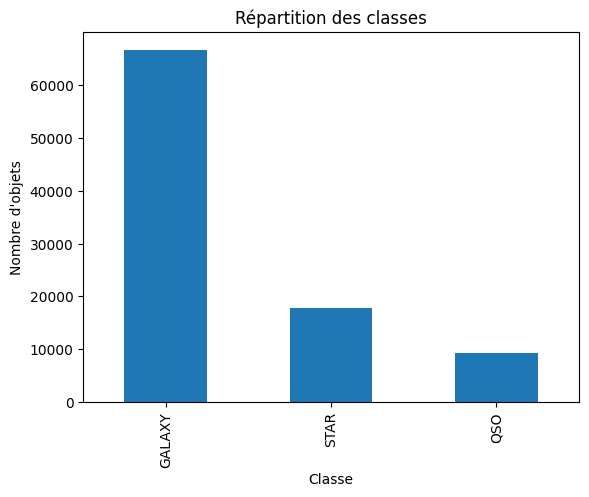

In [7]:

df["class"].value_counts().plot(kind="bar", title="Répartition des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'objets")
plt.show()

Le graphique ci-dessous montre la répartition des classes présentes dans notre jeu de données (`class`).  
On observe une **forte majorité de galaxies (GALAXY)**, suivies par des étoiles (`STAR`) et enfin des quasars (`QSO`).  

Ce **déséquilibre important** doit être pris en compte si l'on construit un modèle de classification, au risque de biaiser les prédictions en faveur de la classe dominante.

| Classe | Nombre d’exemples |
|--------|--------------------|
| GALAXY | ~70 000            |
| STAR   | ~20 000            |
| QSO    | ~10 000            |


### Distribution du redshift


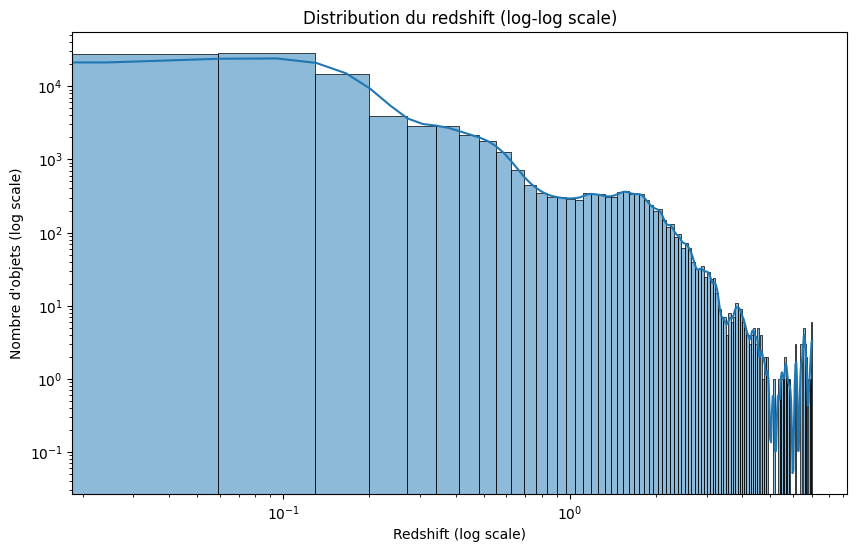

In [8]:
#loglog histogram of redshift
plt.figure(figsize=(10, 6))
sns.histplot(df["redshift"], bins=100, kde=True)
plt.xscale("log")
plt.yscale("log")
plt.title("Distribution du redshift (log-log scale)")
plt.xlabel("Redshift (log scale)")
plt.ylabel("Nombre d'objets (log scale)")
plt.show()


Le graphique ci-dessus montre la distribution de la variable `redshift`, qui mesure le décalage spectral des objets célestes (lié à leur distance et à l’expansion de l’univers).

On observe une **forte concentration autour de 0** : la majorité des objets sont proches de la Terre.  
Quelques cas rares présentent un redshift élevé (souvent > 2), typiques de **quasars très lointains**.

#### Conséquences pour l’analyse :
- La régression risque d’être **biaisée vers les petites valeurs** si l’on ne traite pas ce déséquilibre.
- Il peut être judicieux de **transformer le redshift** (ex. logarithme, normalisation) ou de **filtrer les extrêmes**, en fonction de l’objectif du modèle.


### Distribution du redshift par classe

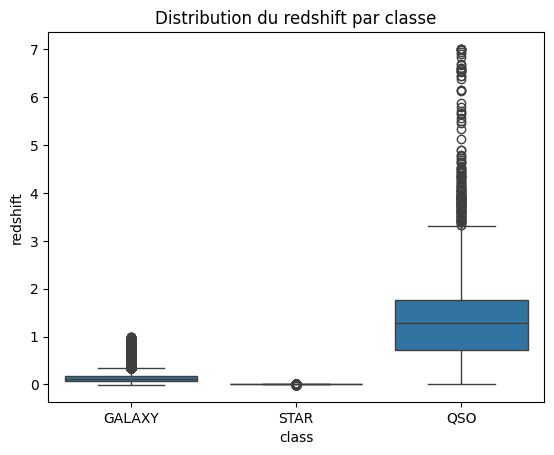

In [9]:
sns.boxplot(x="class", y="redshift", data=df)
plt.title("Distribution du redshift par classe")
plt.show()

Ce boxplot compare la distribution du `redshift` selon les trois classes d’objets célestes (`GALAXY`, `STAR`, `QSO`) :

- Les **étoiles (STAR)** ont un redshift quasi nul, ce qui est attendu puisqu’elles appartiennent à notre galaxie.
- Les **galaxies (GALAXY)** présentent un redshift modéré, généralement inférieur à 0.5.
- Les **quasars (QSO)** ont des redshifts nettement plus élevés, souvent supérieurs à 1, avec une large variabilité. Ce sont des objets très lointains.

#### Interprétation :
- Ce graphique confirme que le `redshift` est une **variable discriminante** entre les classes.
- Il justifie le **filtrage des étoiles** dans un modèle de régression du redshift, puisqu’elles n’apportent pas de diversité utile (toujours proche de 0).



### Matrice de corrélation

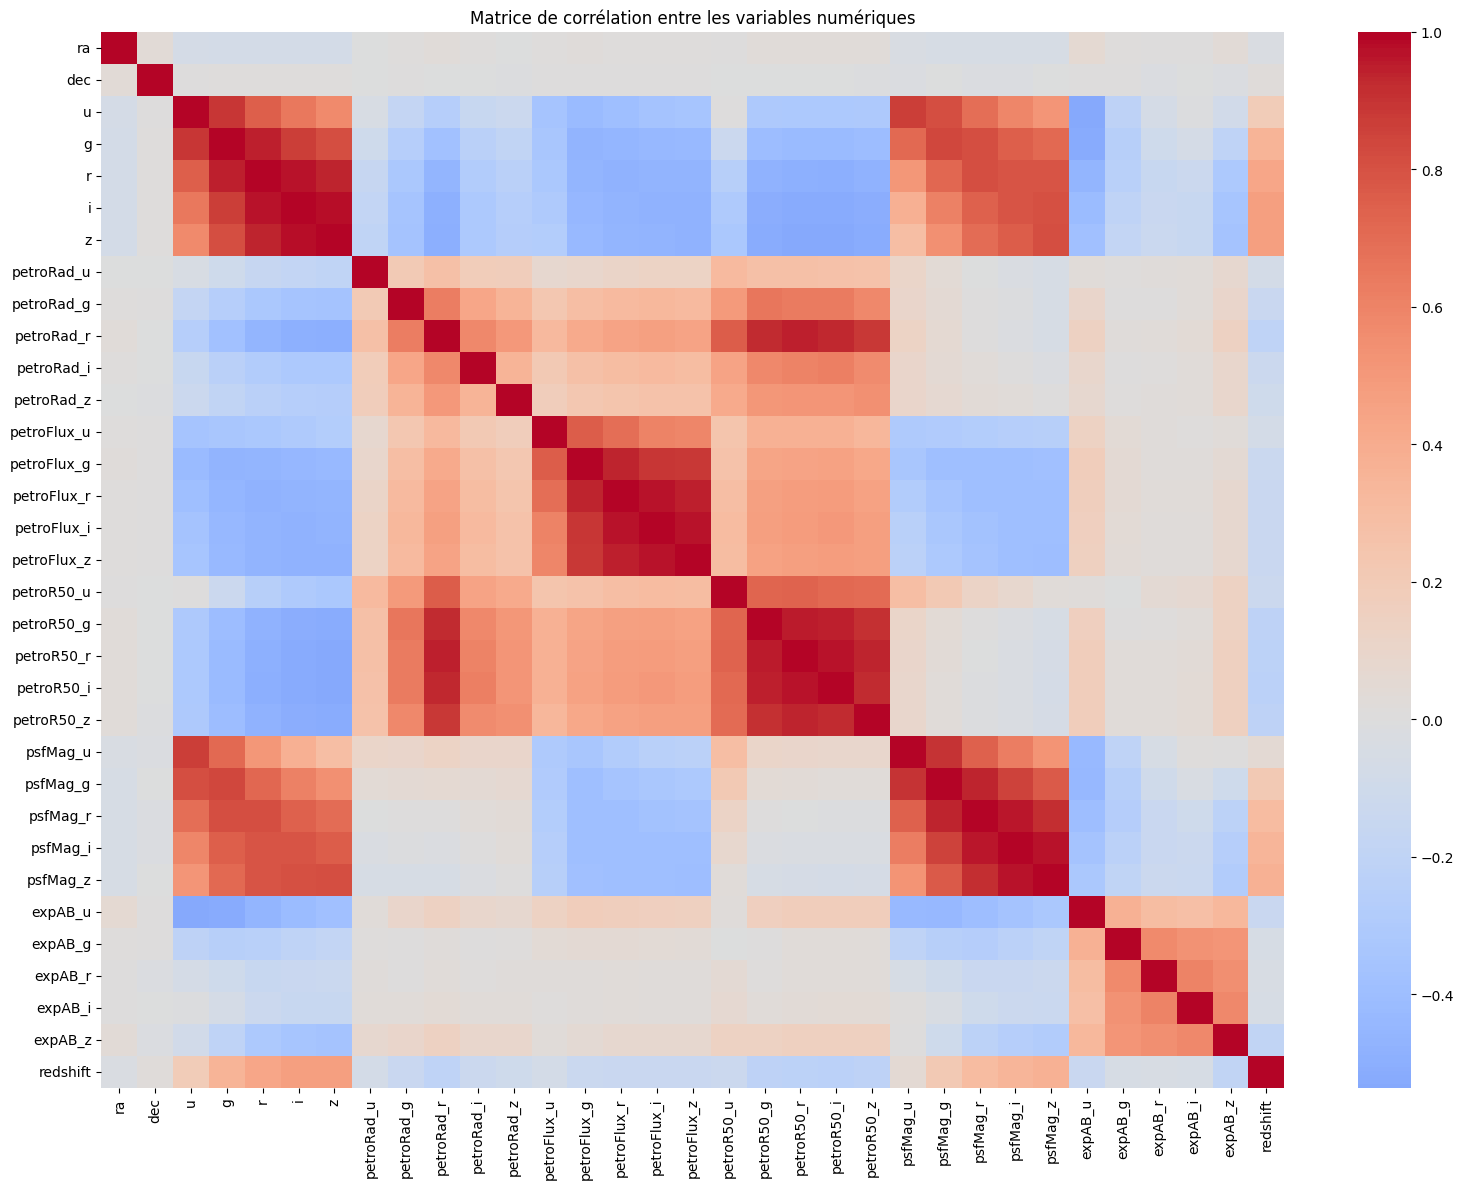

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# On ne garde que les colonnes numériques
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Calcul de la matrice de corrélation
corr_matrix = numeric_df.corr()

# Affichage de la heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, center=0)
plt.title("Matrice de corrélation entre les variables numériques")
plt.tight_layout()
plt.show()


Cette matrice de corrélation, calculée uniquement sur les variables physiques (après suppression des colonnes techniques), met en évidence plusieurs points clés :
- Les magnitudes (`u`, `g`, `r`, `i`, `z`) et les flux (`petroFlux_*`) sont fortement corrélés entre eux, ce qui confirme leur redondance partielle.
- Le `redshift` n’est fortement corrélé à aucune variable individuelle, ce qui suggère que la relation entre les caractéristiques physiques et le décalage spectral est complexe et non linéaire.
- Les variables les plus corrélées négativement à `redshift` sont `petroRad_r`, `petroFlux_i`, `petroFlux_g`, `psfMag_r`, ce qui justifie leur utilisation dans un modèle de régression.
- Les variables de forme (`expAB_*`) sont très corrélées entre elles, mais peu liées au redshift — leur utilité sera à vérifier empiriquement lors de l'entraînement.

Cette analyse nous permet de mieux sélectionner les variables pertinentes et d’envisager, si besoin, des techniques de réduction de dimension ou de régularisation pour éviter les redondances.


### Corrélation entre les variables et le redshift


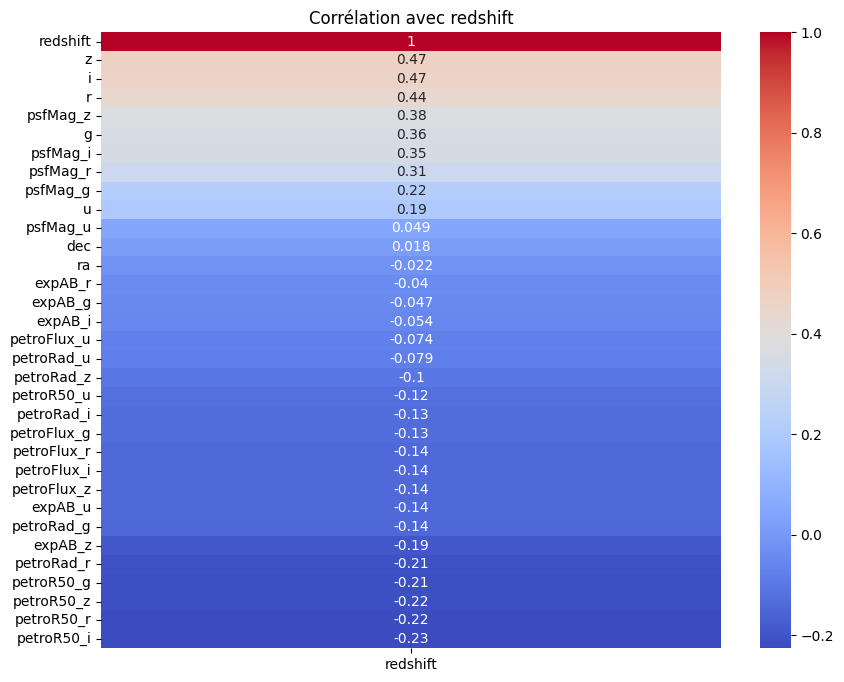

In [11]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr[["redshift"]].sort_values("redshift", ascending=False), annot=True, cmap="coolwarm")
plt.title("Corrélation avec redshift")
plt.show()


Cette heatmap montre la corrélation linéaire de chaque variable avec le `redshift`. Les valeurs proches de +1 indiquent une forte corrélation positive, tandis que celles proches de -1 indiquent une corrélation négative.

#### Principales observations :
- Les variables **`z`**, **`i`** et **`r`** (magnitudes classiques) sont les **plus corrélées positivement** avec le redshift (≈ 0.44 à 0.47).
- Les **magnitudes PSF** sont aussi corrélées, mais un peu moins (max ≈ 0.38 pour `psfMag_z`).
- Les autres variables (flux, rayons, positions, excentricité…) montrent une **corrélation faible voire négative**, suggérant qu'elles sont moins informatives pour la prédiction du redshift.

### Nuage de points

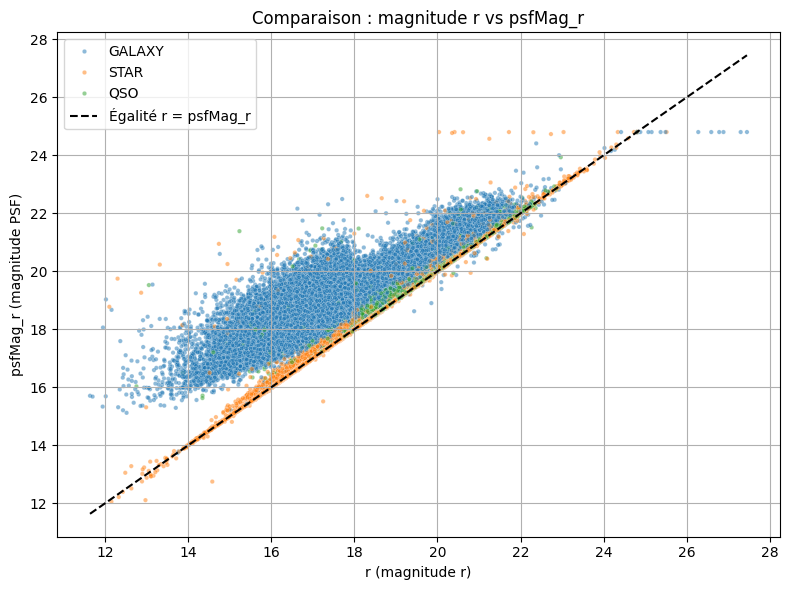

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Nuage de points : r (modelMag) vs psfMag_r
sns.scatterplot(
    data=df,
    x="r",
    y="psfMag_r",
    hue="class",
    alpha=0.5,
    s=10
)

# Ligne diagonale : y = x
min_val = min(df["r"].min(), df["psfMag_r"].min())
max_val = max(df["r"].max(), df["psfMag_r"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Égalité r = psfMag_r")

# Titres et légende
plt.title("Comparaison : magnitude r vs psfMag_r")
plt.xlabel("r (magnitude r)")
plt.ylabel("psfMag_r (magnitude PSF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Les diagrammes de dispersion précédents comparent directement, pour chaque objet, les magnitudes classiques `r` avec les magnitudes PSF `psfMag_r`, en colorant les points par classe (`GALAXY`, `STAR`, `QSO`). Une diagonale d’égalité (`r = psfMag_r`) est tracée pour faciliter la comparaison.

On observe que :
- Les **étoiles (`STAR`)** et les **quasars (`QSO`)** sont alignés très précisément le long de cette diagonale. Cela montre que les magnitudes PSF capturent très bien leur flux lumineux. Ces objets sont ponctuels (non étendus), donc leur lumière est bien modélisée par la PSF.
- Les **galaxies (`GALAXY`)**, au contraire, se situent **au-dessus de la diagonale**, ce qui indique que `psfMag_r` est **plus élevée** (donc **moins lumineuse**) que `r`. Cela signifie que la PSF **sous-estime la luminosité** des galaxies, car elle ignore la lumière diffusée en périphérie de ces objets étendus.

Ces visualisations confirment que :
- Les magnitudes **`psfMag_*`** sont le meilleur choix pour les **étoiles** et **quasars**, car elles sont optimisées pour les objets ponctuels.
- Les magnitudes classiques (`r`, `g`, etc.), souvent dérivées de `modelMag_*`, sont plus adaptées aux **galaxies**, car elles intègrent mieux le flux total.
- Le choix des variables dépend donc de la nature de l’objet : **ponctuel ou étendu**.

> “For galaxies, modelMag usually provides the best available SDSS colors.”  
> “For distant quasars, which are unresolved, psfMag is unbiased and optimal.”  
> “Again, these objects are unresolved, and psfMag is the optimal measure of their brightness.”  
> Source: [https://www.sdss.org/dr12/algorithms/magnitudes/](https://www.sdss.org/dr12/algorithms/magnitudes/)



### Choix des magnitudes en fonction du type d'objet

- Pour les **étoiles** (`STAR`) et les **quasars** (`QSO`), nous utilisons les magnitudes `psfMag_*`, car ce sont des objets ponctuels (unresolved sources). La PSF est optimisée pour ce type de forme, ce qui permet d’obtenir une mesure plus fiable de leur luminosité.

- Pour les **galaxies** (`GALAXY`), nous utilisons les magnitudes classiques `u`, `g`, `r`, `i`, `z` (souvent dérivées de `modelMag_*`), car ces objets sont étendus. Les magnitudes PSF sous-estiment leur flux total en négligeant la lumière diffusée à la périphérie.

Ce choix permet une modélisation plus cohérente et physiquement fondée selon le type d’objet analysé.

In [13]:
# Séparer le DataFrame en deux groupes selon la classe
df_star = df[df["class"] == "STAR"]
df_qso = df[df["class"] == "QSO"]
df_galaxy = df[df["class"] == "GALAXY"]

# Pour les étoiles : utiliser les magnitudes PSF
features_star= ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z"]
X_star = df_star[features_star]
y_star = df_star["redshift"]

# Pour les QSOs : utiliser les magnitudes PSF
features_qso = ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z"]
X_qso = df_qso[features_qso]
y_qso = df_qso["redshift"]


# Pour les galaxies : utiliser les magnitudes classiques (g, r, i, z)
features_galaxy = ["u", "g", "r", "i", "z"]
X_galaxy = df_galaxy[features_galaxy]
y_galaxy = df_galaxy["redshift"]

# Résumé des tailles de chaque dataset préparé
{
    "X_star": X_star.shape,
    "y_star": y_star.shape,
    "X_galaxy": X_galaxy.shape,
    "y_galaxy": y_galaxy.shape,
    "X_qso": X_qso.shape,
    "y_qso": y_qso.shape
}


{'X_star': (17755, 5),
 'y_star': (17755,),
 'X_galaxy': (66662, 5),
 'y_galaxy': (66662,),
 'X_qso': (9321, 5),
 'y_qso': (9321,)}

In [14]:
# Séparation train/test pour STAR, QSO et GALAXY
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_star, y_star, test_size=0.2, random_state=42
)

X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    X_qso, y_qso, test_size=0.2, random_state=42
)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_galaxy, y_galaxy, test_size=0.2, random_state=42
)

In [15]:
# Entraînement du modèle
model_s = RandomForestRegressor(n_estimators=100, random_state=42)
model_s.fit(X_train_s, y_train_s)

model_q = RandomForestRegressor(n_estimators=100, random_state=42)
model_q.fit(X_train_q, y_train_q)

model_g = RandomForestRegressor(n_estimators=100, random_state=42)
model_g.fit(X_train_g, y_train_g)



RandomForestRegressor(random_state=42)

In [16]:
# Prédiction
y_pred_s = model_s.predict(X_test_s)
y_pred_g = model_g.predict(X_test_g)
y_pred_q = model_q.predict(X_test_q)


In [17]:
# Évaluation
print("\nRésultats pour GALAXY :")
print("MSE :", mean_squared_error(y_test_g, y_pred_g))
print("R² :", r2_score(y_test_g, y_pred_g))

print("Résultats pour STAR:")
print("MSE :", mean_squared_error(y_test_s, y_pred_s))
print("R² :", r2_score(y_test_s, y_pred_s))

print("Résultats pour QSO:")
print("MSE :", mean_squared_error(y_test_q, y_pred_q))
print("R² :", r2_score(y_test_q, y_pred_q))



Résultats pour GALAXY :
MSE : 0.0018041347529267854
R² : 0.9034612371971326
Résultats pour STAR:
MSE : 2.2184374973607857e-07
R² : -0.08135069032246833
Résultats pour QSO:
MSE : 0.33586251163928976
R² : 0.46087693522890594


## Résultats de la prédiction du redshift par classe

Nous avons entraîné trois modèles `RandomForestRegressor` indépendants pour prédire le redshift à partir des magnitudes adaptées selon le type d’objet :  
- `psfMag_*` pour les objets ponctuels (`STAR`, `QSO`)
- `u`, `g`, `r`, `i`, `z` pour les objets étendus (`GALAXY`)

###  Résultats

| Classe   | MSE           | R²       | Interprétation rapide                         |
|----------|---------------|----------|----------------------------------------------|
| GALAXY   | 0.0018        | 0.903    |  Très bon modèle, bonne corrélation couleurs/redshift |
| STAR     | 2.2e-7        | -0.081   |  Redshift ≈ 0 → le modèle est inutile ici   |
| QSO      | 0.336         | 0.461    |  Moyen, le modèle capte une tendance mais reste imprécis |

###  Analyse :

- **GALAXY** : Les magnitudes classiques permettent une prédiction fiable du redshift. Le modèle atteint une performance très élevée (R² > 0.90), ce qui montre que les couleurs photométriques sont de bons prédicteurs.
  
- **STAR** : Les étoiles ayant un redshift quasi nul, le modèle n’apprend rien d’utile (R² < 0). Il suffit de prédire `redshift = 0` dans ce cas.

- **QSO** : Le modèle parvient à détecter une tendance globale, mais la grande dispersion des points montre que la prédiction est imprécise. Cela peut être dû à la complexité spectrale des quasars.



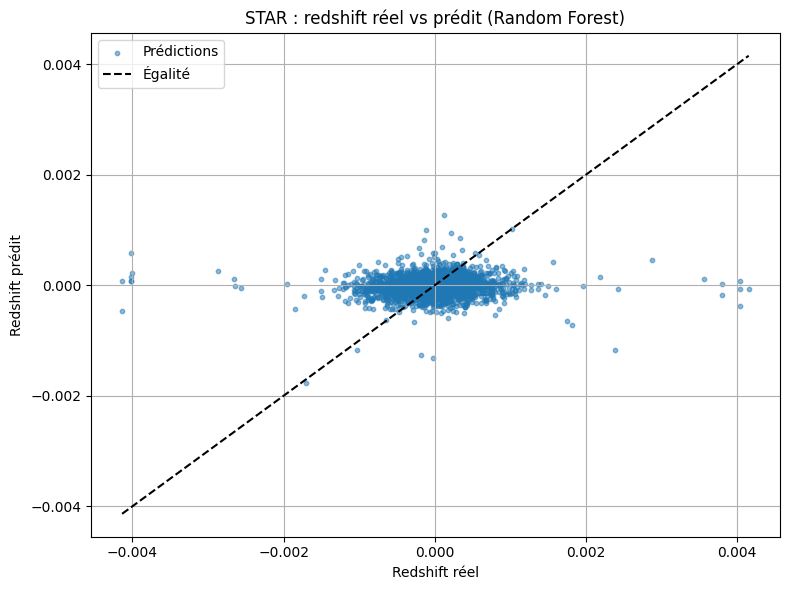

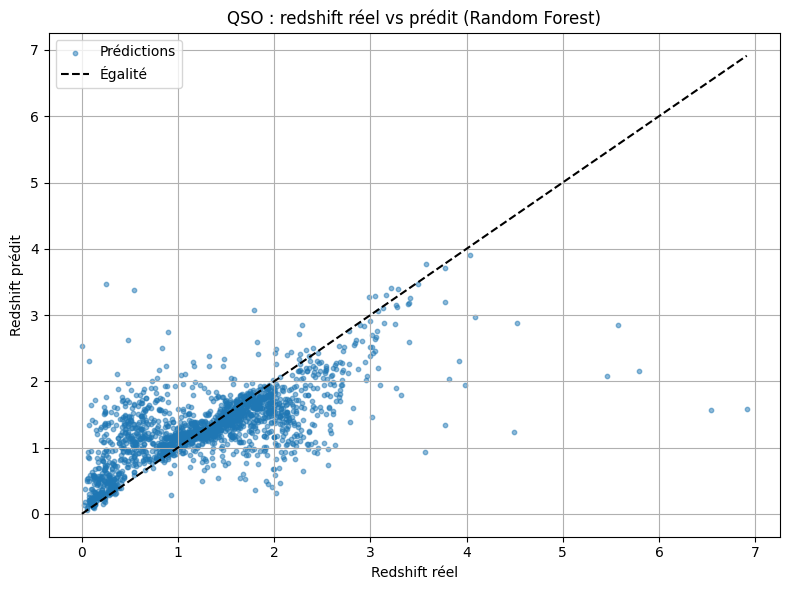

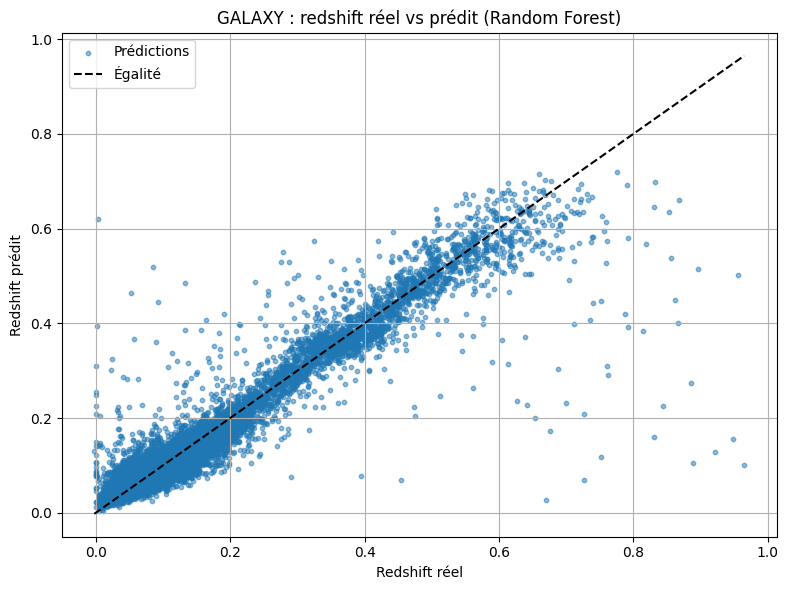

In [18]:
# 1. Graphe pour STAR (redshift ≈ 0, donc peu de dispersion attendue)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_s, y_pred_s, alpha=0.5, s=10, label="Prédictions")
plt.plot([y_test_s.min(), y_test_s.max()], [y_test_s.min(), y_test_s.max()], 'k--', label="Égalité")
plt.title("STAR : redshift réel vs prédit (Random Forest)")
plt.xlabel("Redshift réel")
plt.ylabel("Redshift prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Graphe pour QSO
plt.figure(figsize=(8, 6))
plt.scatter(y_test_q, y_pred_q, alpha=0.5, s=10, label="Prédictions")
plt.plot([y_test_q.min(), y_test_q.max()], [y_test_q.min(), y_test_q.max()], 'k--', label="Égalité")
plt.title("QSO : redshift réel vs prédit (Random Forest)")
plt.xlabel("Redshift réel")
plt.ylabel("Redshift prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Graphe pour GALAXY
plt.figure(figsize=(8, 6))
plt.scatter(y_test_g, y_pred_g, alpha=0.5, s=10, label="Prédictions")
plt.plot([y_test_g.min(), y_test_g.max()], [y_test_g.min(), y_test_g.max()], 'k--', label="Égalité")
plt.title("GALAXY : redshift réel vs prédit (Random Forest)")
plt.xlabel("Redshift réel")
plt.ylabel("Redshift prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualisation des prédictions : redshift réel vs prédit

Nous avons tracé un nuage de points pour chaque classe d’objet, comparant le redshift réel (obtenu par spectroscopie) et le redshift prédit par notre modèle Random Forest.

---

### GALAXY

- Les points suivent une **diagonale bien marquée**, ce qui montre une bonne correspondance entre les valeurs prédites et les vraies.
- Il y a une **faible dispersion** pour les redshifts < 0.6, ce qui est cohérent avec l’évaluation (R² ≈ 0.90).
- Quelques valeurs sont surévaluées ou sous-évaluées aux extrémités, mais globalement le modèle est fiable pour ce type d’objet.

---

### STAR

- Les redshifts réels sont tous très proches de zéro (ce qui est attendu pour les étoiles).
- Le modèle prédit des valeurs proches de zéro mais **sans réel gain d’apprentissage**, ce qui explique le R² négatif.
- Cela confirme qu’un modèle est inutile ici : on peut simplement fixer `redshift = 0` pour tous les objets de type `STAR`.

---

### QSO

- Une **tendance croissante** est visible : le modèle apprend partiellement la structure du redshift des quasars.
- Cependant, la **dispersion est importante**, surtout pour les redshifts > 2.
- Le modèle a du mal à bien capturer les cas complexes (déplacement spectral variable selon la nature du quasar).
- Cela correspond à un R² ≈ 0.46 : le modèle fonctionne, mais reste très perfectible.

---

###  Conclusion

Ces trois visualisations confirment que :
- Le modèle fonctionne **très bien pour les galaxies**.
- Il est **inutile pour les étoiles**, dont le redshift est quasi nul.
- Il est **partiellement utile pour les quasars**, mais nécessite des améliorations (autres features, modèles plus puissants...).


# Prédire la classe (STAR, GALAXY, QSO)


Rapport de classification :
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98      1462
         QSO       0.92      0.77      0.83       201
        STAR       0.88      0.94      0.91       337

    accuracy                           0.96      2000
   macro avg       0.93      0.90      0.91      2000
weighted avg       0.96      0.96      0.95      2000



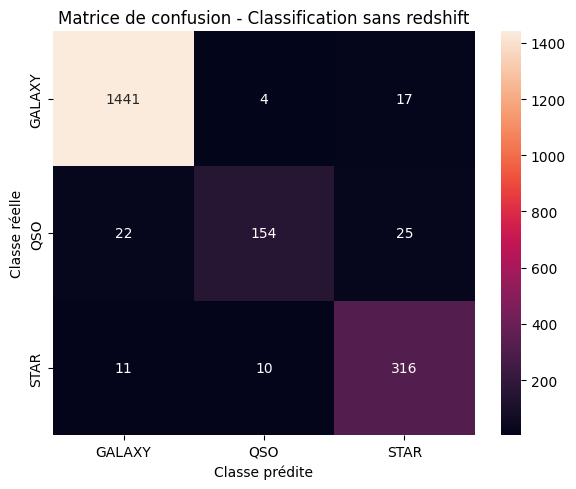

In [ ]:
#Sans le 'redshift' des features
features_classif = [
    "u", "g", "r", "i", "z",
    "petroRad_u", "petroRad_g", "petroRad_r", "petroRad_i", "petroRad_z",
    "petroFlux_u", "petroFlux_g", "petroFlux_r", "petroFlux_i", "petroFlux_z",
    "petroR50_u", "petroR50_g", "petroR50_r", "petroR50_i", "petroR50_z",
    "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
    "expAB_u", "expAB_g", "expAB_r", "expAB_i", "expAB_z",
]

features_classif = [f for f in features_classif if f in df.columns]

# Sous-échantillonnage
df_sampled = df.sample(n=10000, random_state=42)
X = df_sampled[features_classif]
y = df_sampled["class"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Rapport et matrice de confusion
report = classification_report(y_test, y_pred, output_dict=False)
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage
print("Rapport de classification :")
print(report)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion - Classification sans redshift")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.tight_layout()
plt.show()

Rapport de classification :
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.97      1462
         QSO       0.75      0.79      0.77       201
        STAR       0.99      0.99      0.99       337

    accuracy                           0.95      2000
   macro avg       0.90      0.92      0.91      2000
weighted avg       0.95      0.95      0.95      2000



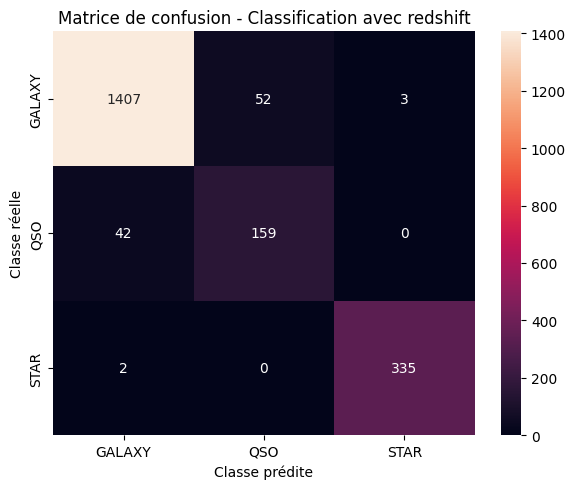

In [12]:
#Avec seulement le redshift comme feature
features_classif = [
    "redshift"
]

features_classif = [f for f in features_classif if f in df.columns]


# Sous-échantillonnage
df_sampled = df.sample(n=10000, random_state=42)
X = df_sampled[features_classif]
y = df_sampled["class"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Rapport et matrice de confusion
report = classification_report(y_test, y_pred, output_dict=False)
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage
print("Rapport de classification :")
print(report)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion - Classification avec redshift")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.tight_layout()
plt.show()

#Commentaire

#conclusion + ce qu'on pourrait faire pour ameliorer